In [ ]:
!pip install gpytorch &> /dev/null
# !pip install botorch &> /dev/null
!pip install forestci &> /dev/null

In [24]:
!pip install botorch==0.10.0 &> /dev/null

In [14]:
# surrogate model: a model that approximates the behavior of a model that is expensive to evaluate
# probabilistic surrogate model: a surrogate model that provides a measure of uncertainity along with the prediction 
# since the surrogate model is an approximation of the expensive model, it is important to consider confidence intervals

# types of probabilistic surrogate models:
# 1. Gaussian Processes (GP)
# 2. eXtreme Gradient Boosting (XGBoost)
# 3. Random Forest (RF)
# 4. Ensemble Multi-layer Perceptron (MLP)

# Loading libraries

import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV # for hyperparameter tuning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import forestci as fci # for uncertainty estimation 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct,WhiteKernel,Matern
from sklearn.metrics import mean_squared_error
from scipy import optimize
import random
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':18})

import warnings
warnings.filterwarnings('ignore')

In [5]:
%cd /Users/khnsakhnm/Documents/Research - Dr. FV/MLOptimization/Module_1

/Users/khnsakhnm/Documents/Research - Dr. FV/MLOptimization/Module_1


In [6]:
df = pd.read_csv('airfoil_self_noise.csv')
print(df.head())

   Frequency  Angle of attack  Chord length  Free stream velocity  \
0        800              0.0        0.3048                  71.3   
1       1000              0.0        0.3048                  71.3   
2       1250              0.0        0.3048                  71.3   
3       1600              0.0        0.3048                  71.3   
4       2000              0.0        0.3048                  71.3   

   Suction side displacement  scaled sound pressure  
0                   0.002663                126.201  
1                   0.002663                125.201  
2                   0.002663                125.951  
3                   0.002663                127.591  
4                   0.002663                127.461  


In [15]:
# split data for train/test
dataset = df.iloc[:,:].values # normalize [0,1]
train_set, val_set = train_test_split(dataset, test_size= 0.2, train_size = 0.4, random_state=18)
x_train = train_set[:,:-1]
y_train = train_set[:,-1]
x_test  = val_set[:,:-1]
y_test  = val_set[:,-1]

# TEST (if true only runs a subset of cases with fewer samples)
TEST = True

# Note that this will take a long time to run if you set to false -- but you can use that to generate figures below
if TEST:
  dataset_sizes =[10]
else:
  dataset_sizes =[10,15,20,25,50,70,80,100]

# specify number of replicates
if TEST:
  samples = 5
else:
  samples = 10

# store error for all samples and dataset sizes
gp_err  = np.zeros([samples, len(dataset_sizes)])
rf_err  = np.zeros([samples, len(dataset_sizes)])
mlp_err = np.zeros([samples, len(dataset_sizes)])
xg_err  = np.zeros([samples, len(dataset_sizes)])

# store how many validation points caught in confidence regions
gp_catch  = np.zeros([samples, len(dataset_sizes)])
rf_catch  = np.zeros([samples, len(dataset_sizes)])
mlp_catch = np.zeros([samples, len(dataset_sizes)])
xg_catch  = np.zeros([samples, len(dataset_sizes)])

# set max number of training samples and initial index list
nmax = x_train.shape[0]
idxlist = np.arange(nmax)

# loop over number of samples
for k in range(samples):

  # loop over number of dataset sizes
  for j, dss in enumerate(dataset_sizes):
    #take a random set of data 
    samp_idx = random.choices(idxlist, k=dss)

    #define taining sets
    x = x_train[samp_idx,:]
    y = y_train[samp_idx]
    
    # train GP
    gp = GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=0.5), alpha =1e-2, normalize_y=True,).fit(x,y.reshape(-1,1))
    gp_pred, gp_var = gp.predict(x_test, return_std=True)

    # train RF
    rf = RandomForestRegressor(n_estimators = 1750, max_features = 'sqrt', max_depth = 17).fit(x, y)
    rf_pred = rf.predict(x_test)
    rf_var = fci.random_forest_error(rf, X_train_shape = x.shape ,X_test = x_test)

    # train ensemble MLP
    ensemble = 25
    mlp = [MLPRegressor(random_state=i, max_iter=500).fit(x, y) for i in range(ensemble)]
    mlp_preds = np.array([mlp[i].predict(x_test) for i in range(ensemble)])
    mlp_pred = mlp_preds.mean(axis=0)
    mlp_std = mlp_preds.std(axis=0) 

    # train Xgboost
    params = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
    }
    def get_xg_std(xg, x_test):
      xg_std = []
      for i in range(len(xg.estimators_)):
        xg_std.append(xg.estimators_[i][0].predict(x_test))
      return np.array(xg_std).std(axis=0)
    xg = GradientBoostingRegressor(**params)
    xg.fit(x, y)
    xg_pred = xg.predict(x_test)
    xg_std = get_xg_std(xg,x_test)

    # calculate mean absolute error
    rf_err[k,j] = np.abs(y_test- rf_pred).mean()
    gp_err[k,j] = np.abs(y_test- gp_pred.flatten()).mean()
    mlp_err[k,j] = np.abs(y_test- mlp_pred).mean()
    xg_err[k,j] = np.abs(y_test- xg_pred).mean()

    # count how many points fall within confidence bounds
    rfcount = 0
    for i in range(len(y_test)):
      if y_test[i]<= rf_pred[i]+2*rf_var[i] and y_test[i]>= rf_pred[i]-2*(rf_var[i]):
        rfcount+=1
    gpcount = 0
    for i in range(len(y_test)):
      if y_test[i]<= gp_pred[i]+2*gp_var[i] and y_test[i]>= gp_pred[i]-2*gp_var[i]:
        gpcount+=1
    mlpcount = 0
    for i in range(len(y_test)):
      if y_test[i]<= mlp_pred[i]+2*mlp_std[i] and y_test[i]>= mlp_pred[i]-2*mlp_std[i]:
        mlpcount+=1
    xgcount = 0
    for i in range(len(y_test)):
      if y_test[i]<= xg_pred[i]+2*xg_std[i] and y_test[i]>= xg_pred[i]-2*xg_std[i]:
        xgcount+=1
    rf_catch[k,j] = rfcount/len(y_test)
    gp_catch[k,j] = gpcount/len(y_test)
    mlp_catch[k,j] = mlpcount/len(y_test)
    xg_catch[k,j] = xgcount/len(y_test)

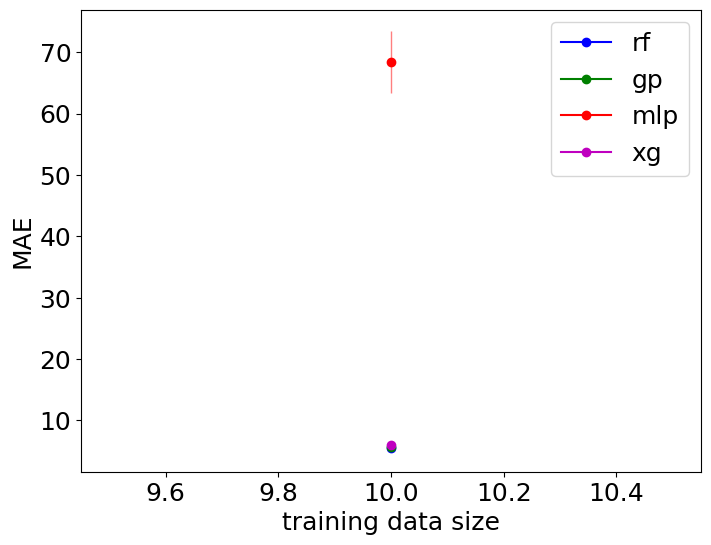

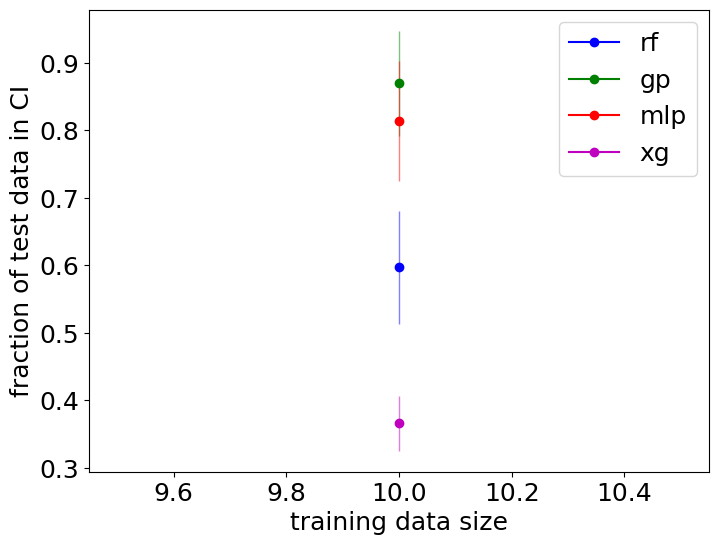

In [16]:
# create MAE plot
colors = ['b', 'g', 'r', 'm']
labels = ['rf', 'gp', 'mlp', 'xg']
model_err = [rf_err, gp_err, mlp_err, xg_err]
plt.figure(figsize=(8,6))
for (i,err) in enumerate(model_err):
  axes = plt.plot(dataset_sizes,  err.mean(axis=0), marker ='o' , color = colors[i], label=labels[i],)
  plt.fill_between(dataset_sizes, err.mean(axis=0)+err.std(axis=0), err.mean(axis=0)-err.std(axis=0), color=colors[i], alpha=0.5)
plt.xlabel('training data size')
plt.ylabel('MAE')
plt.legend();

# create confidence bound fraction plot
model_catch = [rf_catch, gp_catch, mlp_catch, xg_catch]
plt.figure(figsize=(8,6))
for (i,catch) in enumerate(model_catch):
  axes = plt.plot(dataset_sizes,  catch.mean(axis=0), marker ='o' , color = colors[i], label=labels[i],)
  plt.fill_between(dataset_sizes, catch.mean(axis=0)+catch.std(axis=0), catch.mean(axis=0)-catch.std(axis=0), color=colors[i], alpha=0.5)
plt.xlabel('training data size')
plt.ylabel('fraction of test data in CI')
plt.legend();

In [119]:
import torch
import math
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from botorch.optim.fit import fit_gpytorch_mll_scipy
from matplotlib import cm
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, LinearKernel, PeriodicKernel
from gpytorch.constraints.constraints import Interval
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.gp_regression import HeteroscedasticSingleTaskGP

ImportError: cannot import name 'HeteroscedasticSingleTaskGP' from 'botorch.models.gp_regression' (/opt/anaconda3/lib/python3.12/site-packages/botorch/models/gp_regression.py)

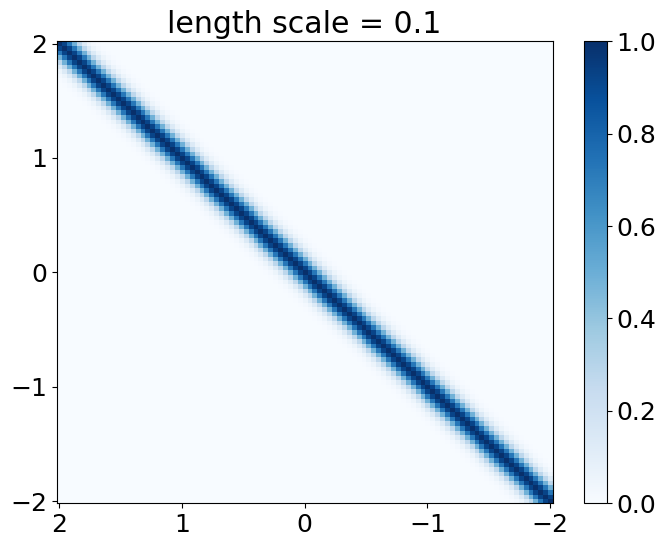

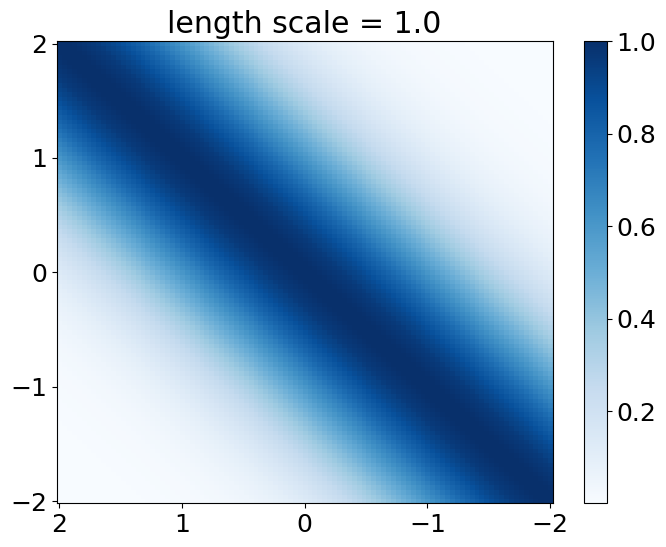

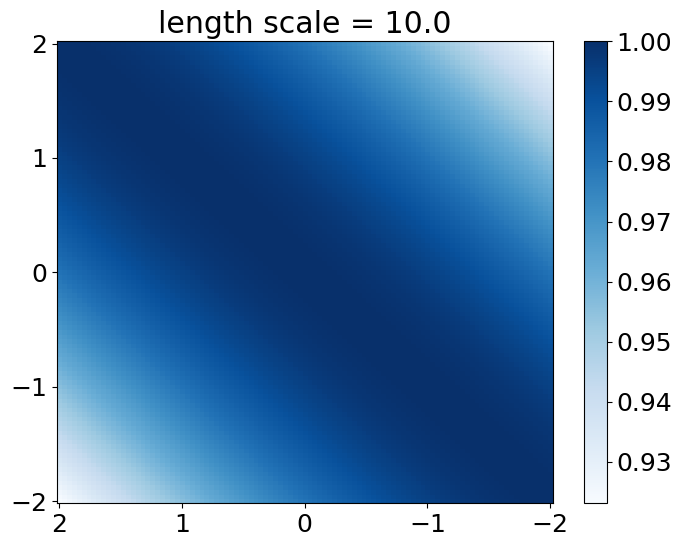

In [34]:
from gpytorch.kernels import RBFKernel

covar = RBFKernel(ard_num_dims = 1)

lengthscale = [0.1,1.0,10.0]

for l in lengthscale:
    covar.lengthscale = l
    x = torch.linspace(-2,2,101)
    X,Y = torch.meshgrid([x,x])
    with torch.no_grad():
        K = covar(x,x)
    K = K.detach().numpy()

    # plot covariance between x vector
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    c = ax.pcolor(X, Y, K, cmap=cm.Blues)
    ax.set_yticks(np.linspace(-2,2,5))
    ax.invert_xaxis()
    ax.set_xticks(np.flip(np.linspace(-2,2,5)))
    ax.set_title(f'length scale = {l}')
    fig.colorbar(c, ax=ax); 

Lengthscale defines how strict or close-monitoring the function should be. The smoothness of the function is rough when its a low value and relatively smoothens with increase in lengthscale.

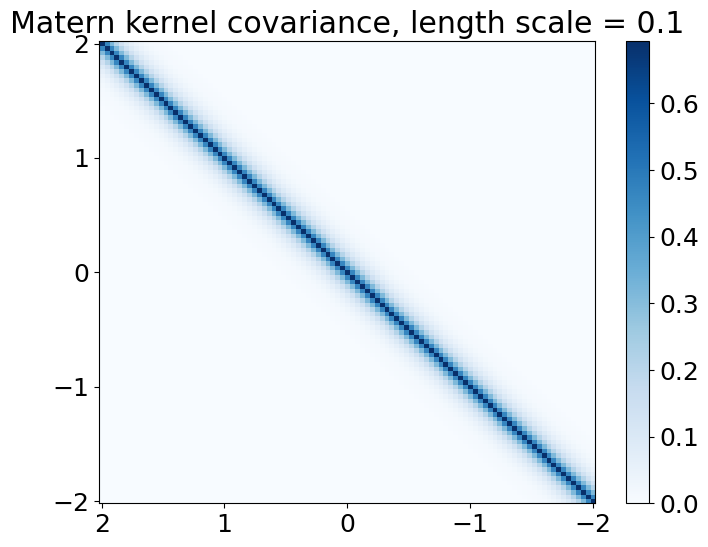

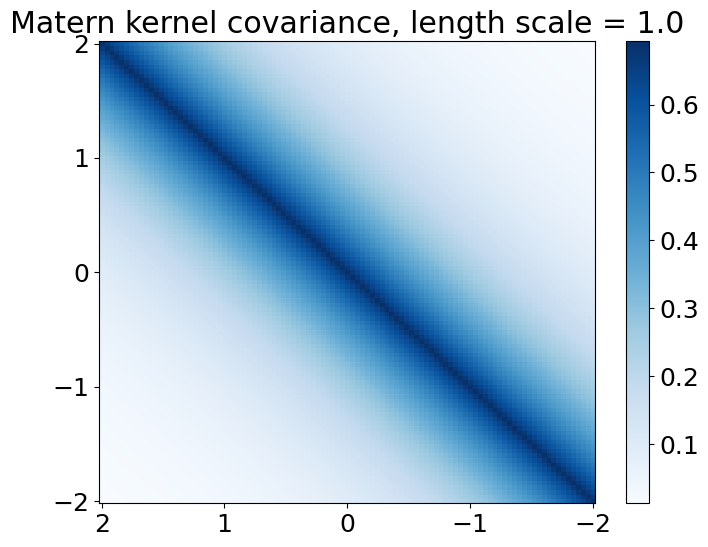

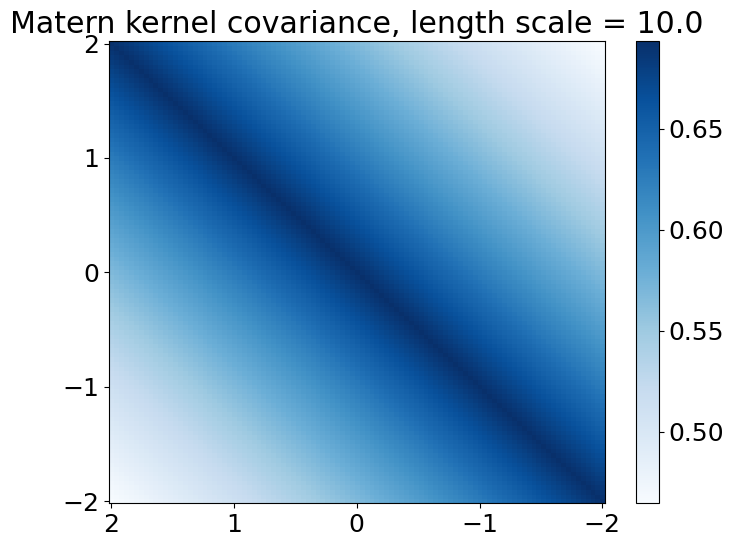

In [40]:
from gpytorch.kernels import MaternKernel, ScaleKernel

# Define the covariance module: scaled Matern kernel with nu=0.5 and ARD for 1 dimension
covar_module = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=1))

lengthscale = [0.1, 1.0, 10.0]
x = torch.linspace(-2, 2, 101)
X, Y = torch.meshgrid(x, x, indexing='ij')

for l in lengthscale:
    covar_module.base_kernel.lengthscale = torch.tensor(l)

    with torch.no_grad():
        K = covar_module(x.unsqueeze(-1)).evaluate()

    K = K.detach().numpy()

    # plot covariance matrix as heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolor(X, Y, K, cmap=cm.Blues)
    ax.set_yticks(np.linspace(-2, 2, 5))
    ax.invert_xaxis()
    ax.set_xticks(np.flip(np.linspace(-2, 2, 5)))
    ax.set_title(f'Matern kernel covariance, length scale = {l}')
    fig.colorbar(c, ax=ax)

plt.show()

Text(0.5, 1.0, 'Random samples from GP prior')

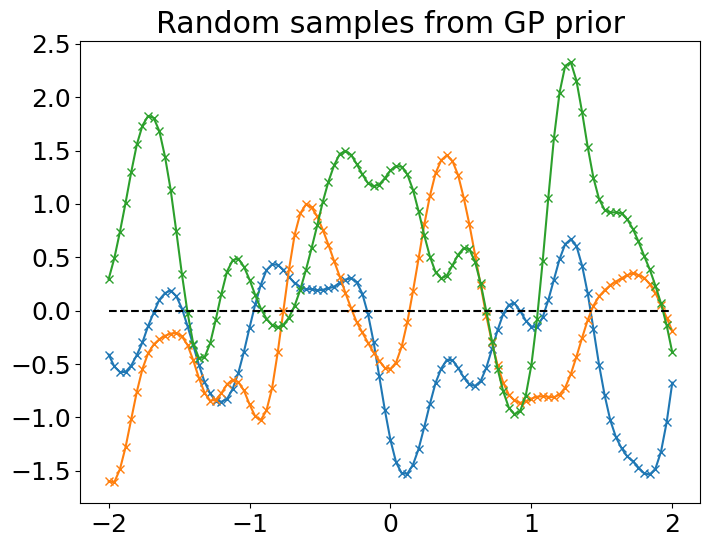

In [48]:
# generate random samples 

covar = RBFKernel(ard_nim_dims = 1)
covar.lengthscale = 0.2

n = 101
x = torch.linspace(-2,2,n)
with torch.no_grad():
    K = covar(x,x)

mean = torch.zeros(n)

L = torch.linalg.cholesky(K+ 1e-6*torch.eye(n))
fig,ax = plt.subplots(1,1, figsize=(8,6))
for i in range(3):
    f = torch.matmul(L, torch.randn((n,1)))
    plt.plot(x.detach().numpy(), f.detach().numpy(), "-x")

plt.plot(x.detach().numpy(), mean.detach().numpy(), 'k--', label='mean')
plt.title('Random samples from GP prior')

In [74]:
# Helper function that takes input data, kernel+likelihood specifications, and plotting options --> return trained model
def get_trained_GP(X, Y, kernel_type, noise_free=False, plot_1d=False, plot_bounds=None):
    """
    This function is used to train a GP model based on the type of kernel that you select.
    This function will be used in modules 1,2,and 3. Save this function for later
    If you delete this cell accidentally, let us know!

    -----------
    Arg:
    X: Features/ Input vector -- torch tensor 
    Y: Mapping/ Target variable vector -- torch tensor
    kernel_type: 'RBF'/'Linear'/'Periodic'/'Matern05'/'Matern15'/'Matern25' select one -- str
    noise_free: True or False (are observations noise free?)
    plot_1d: True or False (should we plot or not?)
    plot_bounds: Tuple of lower and upper bounds (xL, xU)

    ----------
    returns:

    model: a GP model object in train mode -- gpytorch
    """  

    # make sure input data is shaped properly (ntrain by ninputs)
    if X.ndim < 2:
      print("Need to specify as matrix of size ntrain by ninputs")

    # make sure training data has the right dimension
    if Y.ndim == 1:
        Y = Y.unsqueeze(-1)

    # output scaling
    standardize = Standardize(m=Y.shape[-1])
    outcome_transform = standardize

    # select covariance module
    input_dim = X.shape[-1]
    if kernel_type == 'RBF':
        covar_module = ScaleKernel(RBFKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Linear':
        covar_module = ScaleKernel(LinearKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Periodic':
        covar_module = ScaleKernel(PeriodicKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Matern05':
        covar_module = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=input_dim))
    elif kernel_type == 'Matern15':
        covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=input_dim))
    elif kernel_type == 'Matern25':
        covar_module = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=input_dim))

    # set the likelihood
    if noise_free:
      likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5, upper_bound=1e-3))
    else:
      likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5, upper_bound=100))

    # define the model
    model = SingleTaskGP(train_X=X, train_Y=Y, covar_module=covar_module, likelihood=likelihood, outcome_transform=outcome_transform)

    # call the training procedure
    model.outcome_transform.eval()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll_scipy(mll)

    # put in eval mode
    model.eval()

    # plot if specified 
    if plot_1d:
      if input_dim == 1:
        if plot_bounds is None:
          print("Plot bounds not specified!")
        else:
          with torch.no_grad():
            x_list = torch.linspace(plot_bounds[0], plot_bounds[1], 101)
            preds = model.posterior(x_list.unsqueeze(-1))
            mean = preds.mean.squeeze()
            var = preds.variance.squeeze()
            lcb = mean - 2*torch.sqrt(var)
            ucb = mean + 2*torch.sqrt(var)
            plt.figure(figsize=(8,6))
            plt.plot(x_list, mean.detach().numpy())
            plt.fill_between(x_list, lcb.detach().numpy(), ucb.detach().numpy(), alpha=0.2)
            plt.scatter(X.detach().numpy(), Y.detach().numpy(), color ='red', marker ='*')
            samples = preds.rsample(torch.Size([5]))
            for k in range(5):
                plt.plot(x_list, samples[k].detach().numpy(), linestyle='--', alpha=0.7)

            
            plt.xlabel('input')
            plt.ylabel('target')
            plt.legend()
            plt.title(f'GP with {kernel_type} kernel, noise_free={noise_free}')
            plt.show()
      else:
        print("Too many input dimensions to plot!")

    # return the trained model
    return model

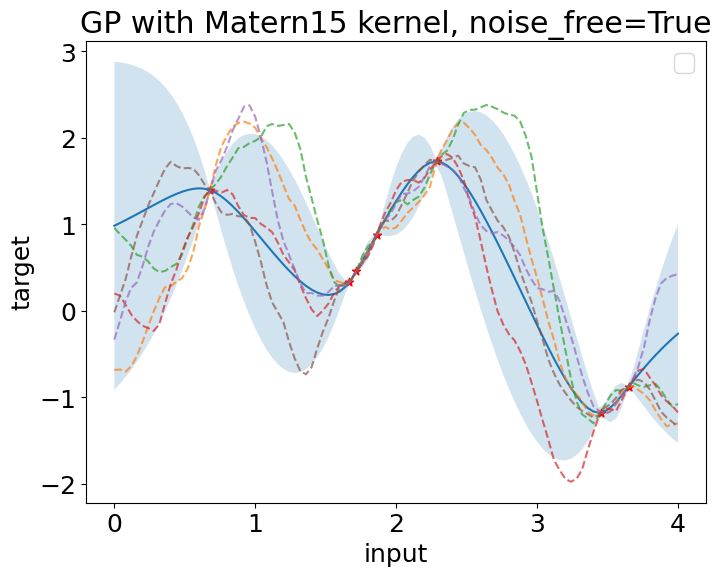

In [76]:
# write a simple 1d function [feel free to modify]
f = lambda x: torch.sin(x) + torch.sin((10.0 / 3.0) * x)

# define input range
x_min, x_max = 0, 4

# generate some number of random data points
Ninit = 7
# torch.manual_seed(8)
x_train = (x_max-x_min)*torch.rand((Ninit,1)) + x_min
y_train = f(x_train)

# fit model
model = get_trained_GP(x_train, y_train, 'Matern15', noise_free=True, plot_1d=True, plot_bounds=(x_min, x_max))
xlist = torch.linspace(x_min, x_max, 1001)


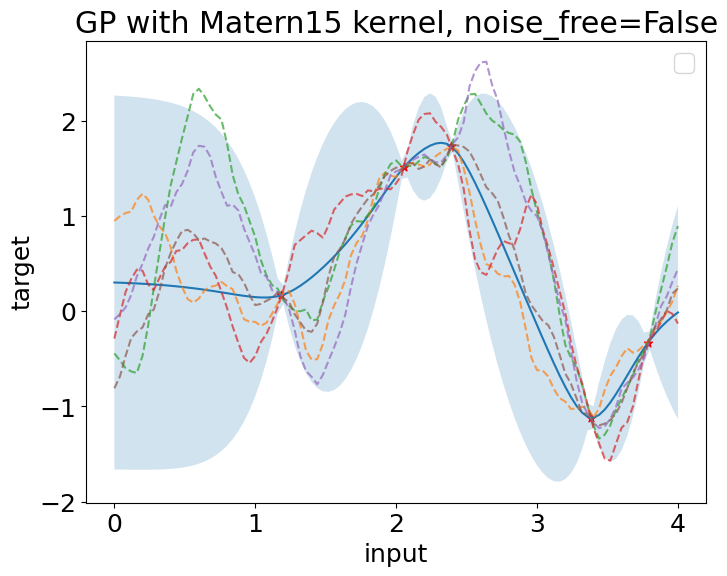

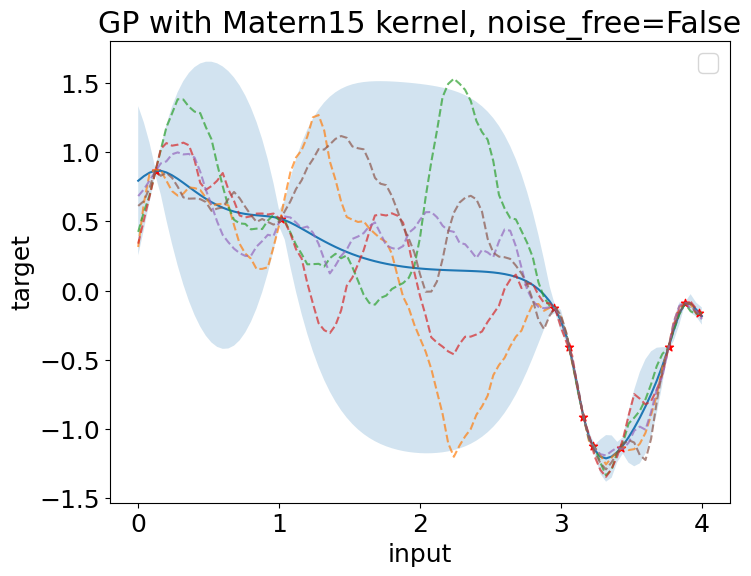

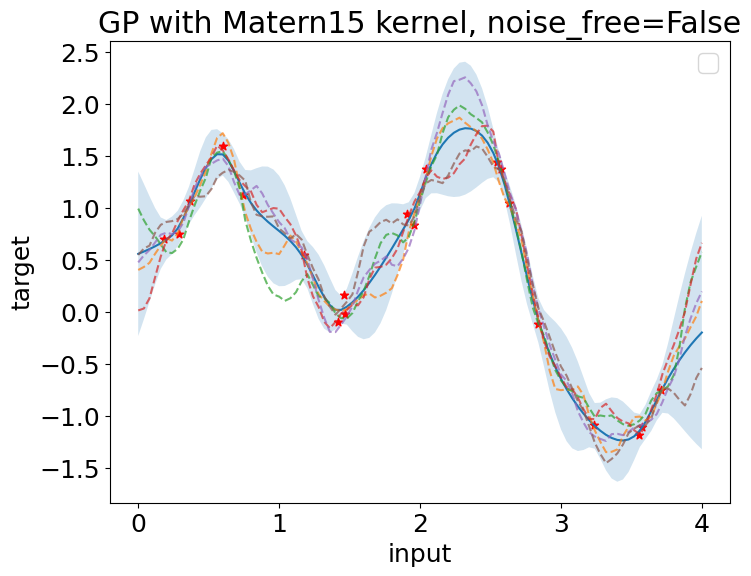

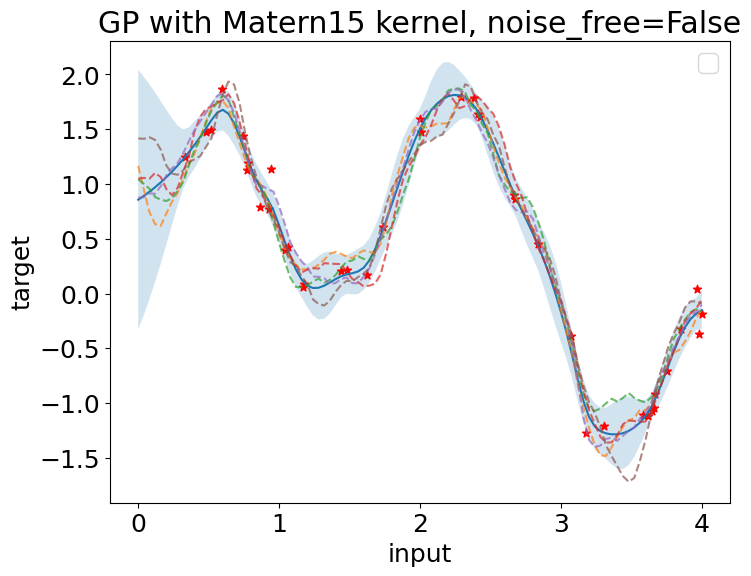

In [77]:
# noisy observations

f = lambda x: torch.sin(x) + torch.sin((10.0 / 3.0) * x)

x_min, x_max = 0,4

Ninit_list = [5,10,20,40]

noise_std = 0.2

torch.manual_seed(8)

for Ninit in Ninit_list:
    x_train = (x_max-x_min)*torch.rand((Ninit,1)) + x_min
    y_train = f(x_train) + noise_std*torch.randn((Ninit,1))

    model = get_trained_GP(x_train, y_train, 'Matern15', noise_free=False, plot_1d=True, plot_bounds=(x_min, x_max))
    xlist = torch.linspace(x_min, x_max, 1001)
    

# HETEROSCEDASTIC GP
There's a downline assumption that GP noise is usually gaussian but that's not 
true in real life scenario. It's usually input dependent or heteroscedastic noise. 

Example:
Imagine a rocket traveling into space and you are trying to measure its position relative to time. Initially your measurements will be fairly confident since the rocket has not traveled very far yet and has not reached its maximum speed yet. 
As time goes on, the uncertainty will increase as the weight of the fuel consumed, atmospheric effects, and distance from the object begin to change. 
A normal Gaussian process would attribute the early and ending behavior the same level of uncertainty. 
This can impact the efficiency of Bayesian optimization and lead to worse decision making due to the reduced model accuracy.

To combat this we use **HETEROSCEDASTIC GP** - we split the model to compute 2 GPs:
1. to measure function outputs 
2. to measure noise levels

At prediction time, the total predictive variance at a point x includes:
1. The model (function) uncertainty: from the GP kernel and posterior.
2. The predicted noise variance (either a single constant value or, in heteroscedastic models, the value appropriate for x)

The posterior is likely to be more complex and we have some methods to perform operation with heteroskedastic noise:
1. MCMC HGP : 
They broke down the HGP into two seperate GPs with one predicting the function output and the other predicting noise. In order to model the noise prediction, they used Markov Chain Monte Carlo (MCMC) to obtain estimates of the noise function. Although this allowed for successfully modeling the noisy data, it was computationally slow and resource intensive.
2. Most Likely HGP: 
The variance of the *function output GP* is used as the *training data* for the *noise GP*. These *GPs are then combined to form the HGP*. This process is then iterated over until convergence. One issue with this mesthod is that convergence is not well defined and some convergence issues occur where the process can infinitely oscillate towards a solution but never find one.
3. Improved Most Likely HGP:
The function output GP is used to calculate the residuals between the mean prediction and the known data points. These residuals are then used to make noise predictions at these locations using a noise handling GP. The noise levels are then updated using a scaling factor and predictions can be made. 
Has stabilty issues.
4. Variational HGP:
This method used variational methods and KL divergence from information theory to seperate the output prediction and noise prediction into seperate functions which could be modeled using Guassian processes.  A lower bound on the prior was also constructed to ensure the variational models are as accurate as possible. These models are then combined and Guassian quadrature is used to make the posterior predictions. This method is one of the most accruate and computationally efficent methods developed and does not suffer from convergence or stability issues.




### GLOSSARY
* *heteroscedastic noise* - variance of noise is not constant across all input, rather it changes with the input


In [108]:
# combining standard GP and Heteroscedastic GP
# Part 1: constant noise - standard GP
# Define model functions
def f(x):
    f = 2*np.sin(2*np.pi*x)
    return f

def g(x):
    g = x + 0.5
    return g

def data_gen(x):
    fval = f(x)
    gval = g(x)
    Z = np.random.randn(np.shape(x)[0])
    y = fval + Z*gval
    return y

# Define model parameters
np.random.seed(7)
xL = 0
xU = 1
x_plot = np.linspace(xL,xU,1000)

# Create mean and confdence bounds
mean_true = f(x_plot)
conf_upper = f(x_plot) + g(x_plot)
conf_lower = f(x_plot) - g(x_plot)

# Generate some data
n_train = 20
x_train = np.random.rand(n_train)
y_train = data_gen(x_train)

In [109]:
print(x_train.shape, y_train.shape)

(20,) (20,)


In [110]:
print(isinstance(x_plot, np.ndarray))
print(x_plot.shape)

True
(1000,)


In [111]:
isinstance(x_train, np.ndarray)

True

In [112]:
isinstance(y_train, np.ndarray)

True

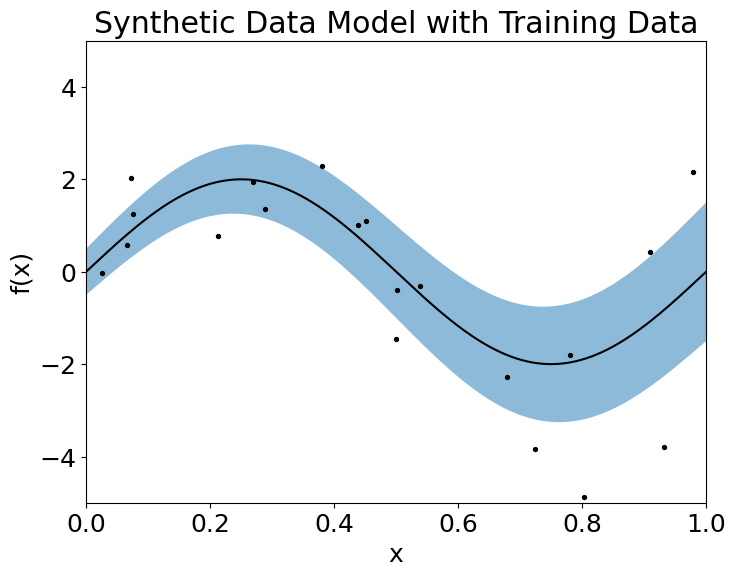

In [113]:
# Plot mean and confidence bounds
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(x_plot,mean_true, 'k')
ax.fill_between(x_plot,conf_upper,conf_lower, alpha = 0.5)
ax.scatter(x_train,y_train, 8, 'k')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Synthetic Data Model with Training Data')
ax.set_xlim(0,1)
ax.set_ylim(-5,5);

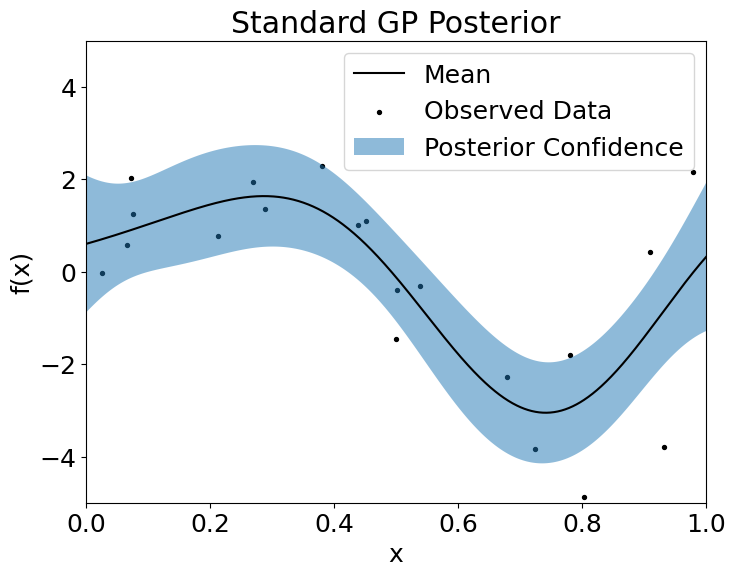

In [115]:
# Transform data to torch
plot_X = torch.from_numpy(x_plot)
train_X = torch.from_numpy(x_train).unsqueeze(-1)
train_Y = torch.from_numpy(y_train).unsqueeze(-1)

# Begin with standard GP
model = SingleTaskGP(train_X, train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll_scipy(mll)

# Extract GP posterior for plotting
with torch.no_grad():
    posterior = model.posterior(plot_X)
    mean_GP = posterior.mean
    stdev_GP = posterior.variance
    lower_GP, upper_GP = posterior.mvn.confidence_region()

    fig, ax = plt.subplots(1,1,figsize = (8,6))

    ax.plot(x_plot,mean_GP.numpy(), 'k')
    ax.scatter(x_train,y_train, c='k', s=8)
    ax.fill_between(x_plot,lower_GP.numpy(),upper_GP.numpy(), alpha = 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title('Standard GP Posterior')
    ax.legend(['Mean','Observed Data','Posterior Confidence'])
    ax.set_xlim(xL,xU)
    ax.set_ylim(-5,5)

In [4]:
conda activate botorch064


CondaError: Run 'conda init' before 'conda activate'


Note: you may need to restart the kernel to use updated packages.


In [5]:
!conda install jupyter -y
!pip install ipykernel

Channels:
 - defaults
 - pytorch
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [6]:
# Residual HGP 

from botorch.models import HeteroskedasticSingleTaskGP

residual = torch.tensor(model.posterior(train_X).mean.detach().numpy() - train_Y.detach().numpy())
nu = 2
z = torch.pow(residual, 2)

model = HeteroskedasticSingleTaskGP(train_X, train_Y, z)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll_scipy(mll)

with torch.no_grad():
    posterior = model.posterior(plot_X)
    mean = posterior.mean
    stdev = posterior.variance
    lower, upper = posterior.mvn.confidence_region()

    fig, ax = plt.subplots(1,1,figsize = (8,6))

    ax.plot(x_plot,mean.numpy(), 'k')
    ax.scatter(x_train,y_train, c='k', s=8)
    ax.fill_between(x_plot,lower.numpy(),upper.numpy(), alpha = 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title('Heteroscedastic GP Posterior')
    ax.legend(['Mean','Observed Data','Posterior Confidence'])
    ax.set_xlim(xL,xU)
    ax.set_ylim(-5,5)

AssertionError: 